In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import polatory
from scipy import interpolate
from scipy import spatial
import seaborn as sns

from utils import (config_rcparams,
                   set_axes_equal,
                   set_3d_params,
                   estimate_normals,
                   orient_normals)

In [2]:
config_rcparams()

In [3]:
%config InlineBackend.figure_format = 'retina'

# Toy example: Gaussian-pattern compliance-zone boundary

In [4]:
def f(x, y, A=1, x0=0, y0=0, theta_x=1, theta_y=1):
    """2D Gaussian function.

    Parameters
    ----------
    x : float of numpy.ndarray
        Spatial coordinate(s), x-direction
    y : float of numpy.ndarray
        Spatial coordinate(s), y-direction
    A : float, optional
        Amplitude    
    x0 : float, optional
        Center of the blob, x-direction
    y0 : float, optional
        Center of the blob, y-direction
    theta_x : float, optional
        Spread of the blob, x-direction
    theta_y : float, optional
        Spread of the blob, y-direction

    Returns
    -------
    float or numpy.ndarray
        Value(s) of the Guassian function, z-direction
    """
    return A * np.exp(
        - (x - x0) ** 2 / (2 * theta_x ** 2)
        - (y - y0) ** 2 / (2 * theta_y ** 2))

In [5]:
# generate surface points of the compliance-zone boundary
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
X, Y = np.meshgrid(x, y)
Z = f(X, Y, A=2, theta_x=0.3, theta_y=0.3)

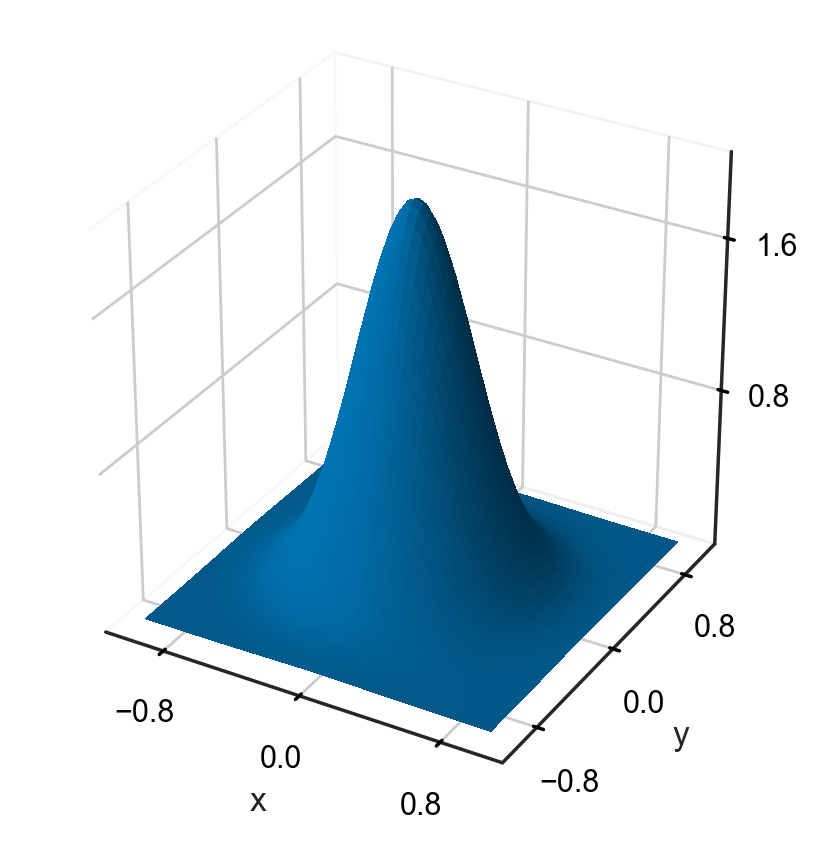

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax = set_3d_params(ax)
surf = ax.plot_surface(X, Y, Z, lw=0, cstride=1, rstride=1, antialiased=False)

## Normal estimation at each evaluation point

In [7]:
# create the point cloud and generate a unit normal at each point
points = np.c_[X.ravel(), Y.ravel(), Z.ravel()]
normals = estimate_normals(points, k=20)
normals = orient_normals(points, normals, k=20)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


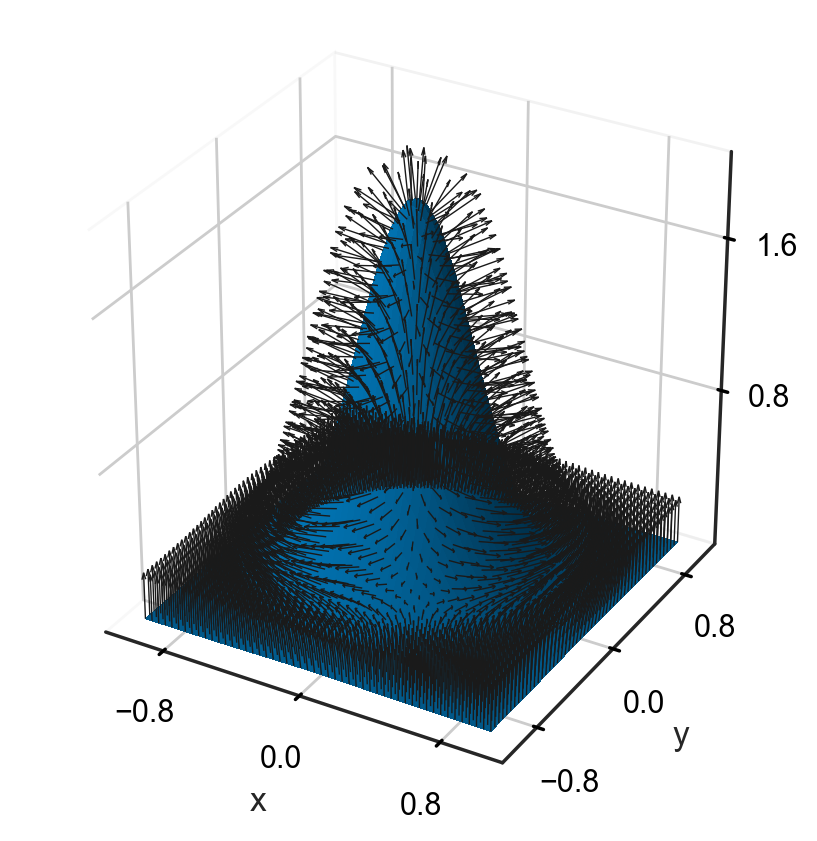

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax = set_3d_params(ax)
surf = ax.plot_surface(X, Y, Z, lw=0, cstride=1, rstride=1, antialiased=False)
q = ax.quiver(*points.T, *normals.T, color='k',
              lw=0.5, length=0.25, arrow_length_ratio=0.15)

## How to check whether a point is within the compliance-zone boundaries?

### Method 1: Radial basis function (RBF) interpolation

The first method in this notebook interpolates the points on the surface of the compliance-zone boundaries in 3D space by using RBF.

Herein, the [`polatory`](https://github.com/polatory/polatory) package, a fast and memory-efficient framework written in C++, is used.
This package implements the approach proposed in Carr et al. "[Reconstruction and representation of 3D objects with radial basis functions](https://doi.org/10.1145/383259.383266)," in *Computer Graphics SIGGRAPH 2001 proceedings*, pp. 67-76, 2001.

`polatory` is fairly easy to install. The first step is the build process:
- On Windows: https://github.com/polatory/polatory/blob/main/docs/build-windows.md
- On Ubuntu 22.04+: https://github.com/polatory/polatory/blob/main/docs/build-ubuntu.md
- On MacOS: https://github.com/polatory/polatory/blob/main/docs/build-macos.md

After that, go to the cloned repository and (inside the virutal environemnt) run

```bash
python setup.py install

```
to be able to use `polatory` in Python.

**Method 1** is divided into 4 simple steps:

**Step 1** &ensp; Define the query point, $p$

**Step 2** &ensp; Create the signed-distance function and sample points and values for interpolation purposes

**Step 3** &ensp; Interpolate sampled points by using RBF (bi-harmonic kernel)

**Step 4** &ensp; Evaluate the interpolant at $p$; if the value is positive, the point is located out of the compliance-zone boundaries

In [9]:
# step 1
point_out = np.array([-1, -1, 1])  # out of the compliance-zone boundaries

In [10]:
# step 2
pairwise_distance = spatial.distance.pdist(points)
min_distance = np.min(pairwise_distance)
max_distance = np.max(pairwise_distance)
sdf = polatory.SdfDataGenerator(points, normals, min_distance, max_distance)
sdf_points, sdf_values = sdf.sdf_points, sdf.sdf_values
# additional cleanup - optional
mask = polatory.DistanceFilter(sdf_points, 1e-4).filtered_indices
sdf_points, sdf_values = sdf_points[mask, ...], sdf_values[mask]

In [11]:
# step 3
rbf = polatory.Biharmonic3D([1.0])
model = polatory.Model(rbf, poly_dimension=2, poly_degree=1)
interp = polatory.Interpolant(model)
interp.fit(sdf_points, sdf_values, absolute_tolerance=1e-4)

Compressed and set M2L operators (12384000 B) in 0.148914sec.
Compressed and set M2L operators (12384000 B) in 0.0775213sec.
Compressed and set M2L operators (12384000 B) in 0.0810542sec.
Compressed and set M2L operators (12384000 B) in 0.0777886sec.
Compressed and set M2L operators (12384000 B) in 0.100865sec.
Compressed and set M2L operators (12384000 B) in 0.0788152sec.
Compressed and set M2L operators (12384000 B) in 0.0766759sec.
Compressed and set M2L operators (12384000 B) in 0.0779562sec.
   level       n_domains        n_points
       1             482            5198
       0               1            1058
Compressed and set M2L operators (753408 B) in 0.00311685sec.
Compressed and set M2L operators (753408 B) in 0.00284553sec.
Compressed and set M2L operators (753408 B) in 0.00324988sec.
Compressed and set M2L operators (753408 B) in 0.0030992sec.
Compressed and set M2L operators (753408 B) in 0.00406694sec.
Compressed and set M2L operators (753408 B) in 0.00354528sec.
Comp

In [12]:
# step 4
val = interp.evaluate(point_out)

Compressed and set M2L operators (12384000 B) in 0.0768902sec.
Compressed and set M2L operators (12384000 B) in 0.0885968sec.
Compressed and set M2L operators (12384000 B) in 0.0743473sec.
Compressed and set M2L operators (12384000 B) in 0.0759535sec.


In [13]:
if val > 0:
    print(f'The point is OUT of the compliance-zone boundaries')
else:
    print(f'The point is WITHIN the compliance-zone boundaries')

The point is OUT of the compliance-zone boundaries


### Method 2

**Step 1** &ensp; Define the query point, $p$

**Step 2** &ensp; Find $k$ points on the compliance-zone boundary nearest to $p$ 

**Step 3** &ensp; Compute the scalar product between the relative position vector to $p$ from each of the $k$-nearest neighbors and the corresponding unit normal vector, $\mathbf{\hat{n}_i}$:

$$ \lvert \mathbf{p} - \mathbf{x_i} \rvert \cdot {\mathbf{\hat{n}_i}} $$

**Step 4** &ensp; Count the negative vs. positive values obtained in the previous step; if the ratio of the positive numbers is higher compared to the positive numbers, the point is located out of the compliance-zone boundaries

In [14]:
# step 1
point_out = np.array([1, -1, 2])  # out of the compliance-zone boundaries

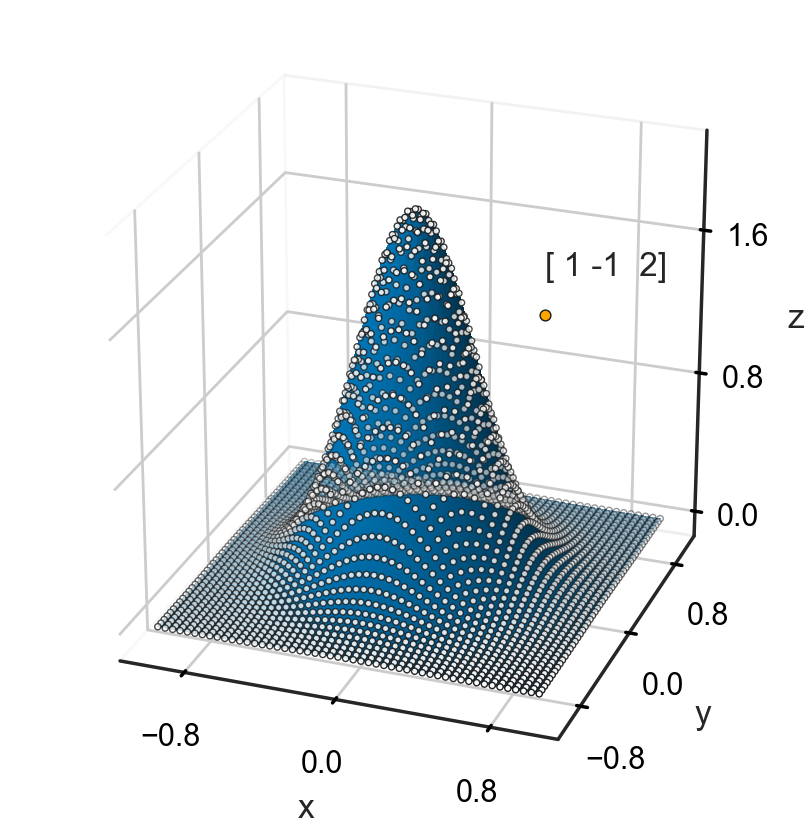

In [15]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, lw=0, cstride=1, rstride=1, antialiased=False)
ax.scatter(*points.T, fc='w', ec='k', s=5, lw=0.5)
ax.scatter(*point_out, fc='orange', ec='k', s=15, lw=0.5)
ax.text(*point_out + [0, 0, 0.2], f'{point_out}')
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [16]:
# step 2
tree = spatial.KDTree(points)
dist, idx = tree.query(point_out, k=20)

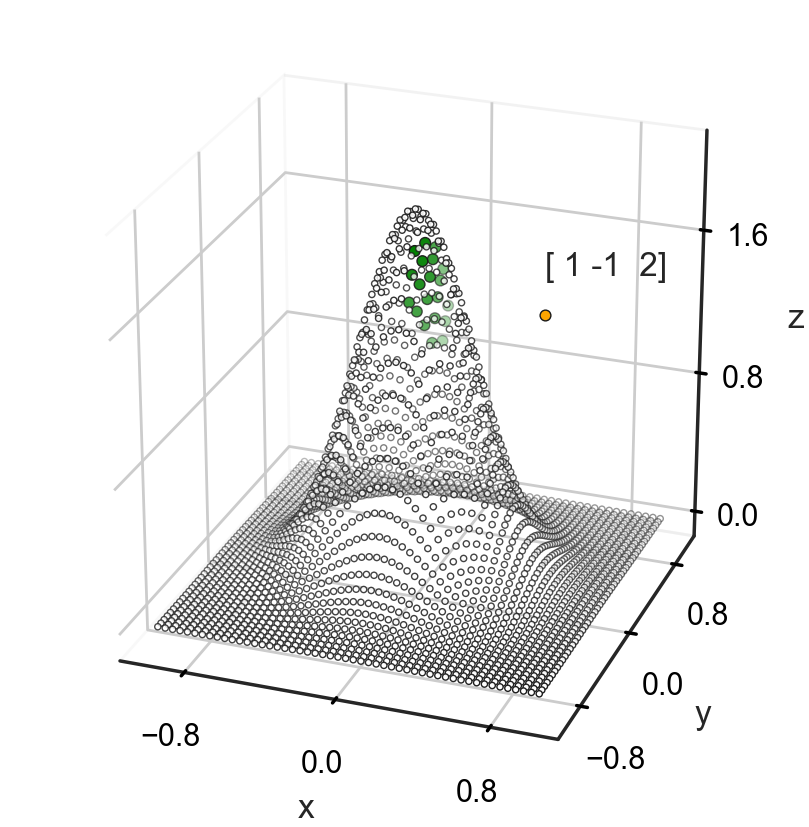

In [17]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*np.delete(points, idx, axis=0).T, fc='w', ec='k', s=5, lw=0.5)
ax.scatter(*points[idx, ...].T, fc='green', ec='k', s=15, lw=0.5)
ax.scatter(*point_out, fc='orange', ec='k', s=15, lw=0.5)
ax.text(*point_out + [0, 0, 0.2], f'{point_out}')
ax = set_3d_params(ax)
ax.view_init(25, -70);

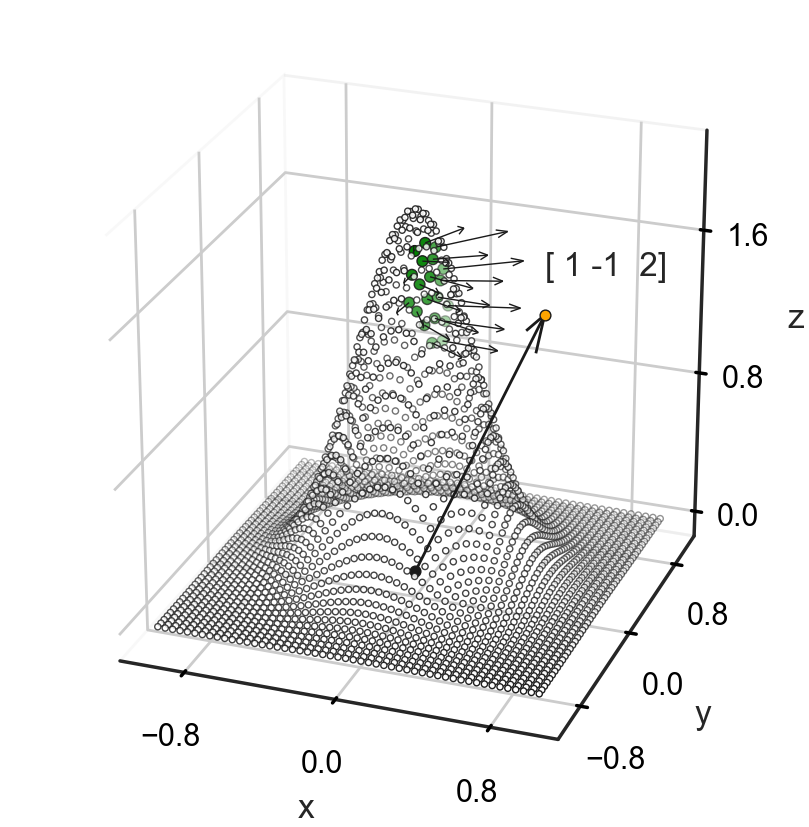

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*np.delete(points, idx, axis=0).T, fc='w', ec='k', s=5, lw=0.5)
ax.scatter(*points[idx, ...].T, fc='green', ec='k', s=15, lw=0.5)
ax.quiver(*points[idx, ...].T, *normals[idx, ...].T, color='k',
          lw=0.5, length=0.5, arrow_length_ratio=0.15)
ax.scatter(*point_out, fc='orange', ec='k', s=15, lw=0.5)
ax.scatter(0, 0, 0, fc='k', ec='k', s=15, lw=0.5)
ax.quiver(0, 0, 0, *point_out, color='k',
          lw=1, arrow_length_ratio=0.1)
ax.text(*point_out + [0, 0, 0.2], f'{point_out}')
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [19]:
# step 3
prod = np.sum((point_out - points[idx]) * normals[idx], axis=1)

In [20]:
# step 4
prob = np.sum(prod > 0) / prod.size
if prob > 0.5:
    print(f'The point is OUT of the compliance-zone boundaries ({prob:.2f})')
else:
    print(f'The point is WITHIN the compliance-zone boundaries ({1-prob:.2f})')

The point is OUT of the compliance-zone boundaries (1.00)


### Simple function to check whether a point is within the compliance-zone boundaries

The first presented implementation is based on the **Method 1** as it is more robust.
However, RBF interpolation is done by using `SciPy` instead of `polatory` for speed and controlability sake.

In [21]:
# this code is ready to be used after installation of `polatory`
def assess_compliance(query_points,
                      evaluation_points,
                      normals=None,
                      k=None,
                      **kwargs):
    """Return the value indicating whether the point is within or out
    of the complianze-zone boundary whose surface is represented as the
    unstructured point cloud.

    Parameters
    ----------
    query_points : numpy.ndarray
        Tested point(s) of shape (M, 3), M is the number of points
        being assessed for compliance
    evaluation_points : numpy.ndarray
        Point cloud of shape (N, 3), N is the number of points on the
        surface of the compliance-zone boundary
    normals : numpy.ndarray, optional
        Normals of shape (N, 3), where N is the number of points in the
        point cloud. Normals should point out of the compliance zone
    k : float, optional
        Number of nearest neighbors for normal estimation
    **kwargs : dict, optional
        Additional keyword arguments for normal estimation if normals
        are not provided

    Returns
    -------
    float
        Interpolated value. For values > 0, the point is expected to be
        located out of the compliance zone
    """
    # handle additional dependencies
    try:
        import polatory
    except ModuleNotFoundError as e:
        print(e, 'install it before proceeding', sep=', ')
    
    # handle points
    size = evaluation_points.shape[0]
    if size < 10:
        raise ValueError('Number of points must be > 10')  # for robustness

    # compute normals
    if normals is None:
        if not k:
            k = int(2 * np.log(size))
            if k < 5:
                k = 5
            elif k > 30:
                k = 30
        normals = estimate_normals(evaluation_points, k)
        normals = orient_normals(evaluation_points, normals, k)
    normals = normals / np.linalg.norm(normals, axis=1).reshape(-1, 1)

    # sample points sampled from the signed distance function
    pairwise_distance = spatial.distance.pdist(evaluation_points)
    min_distance = np.min(pairwise_distance)
    max_distance = np.max(pairwise_distance)
    sdf = polatory.SdfDataGenerator(evaluation_points,
                                    normals,
                                    min_distance,
                                    max_distance)
    
    # remove points that are too close to each other
    mask = polatory.DistanceFilter(sdf.sdf_points, 1e-4).filtered_indices
    sdf_points = sdf.sdf_points[mask, ...]
    sdf_values = sdf.sdf_values[mask]

    # interpolate SDF points with RBF, Carr et al. 2001
    interp = interpolate.RBFInterpolator(sdf_points,
                                         sdf_values,
                                         kernel='linear',  # biharmonic kernel
                                         degree=1)
    val = interp(np.atleast_2d(query_points))
    return val

In [22]:
# define query points to test an assessment function
query_points = np.c_[X.ravel(), Y.ravel(), np.ones_like(X).ravel()]

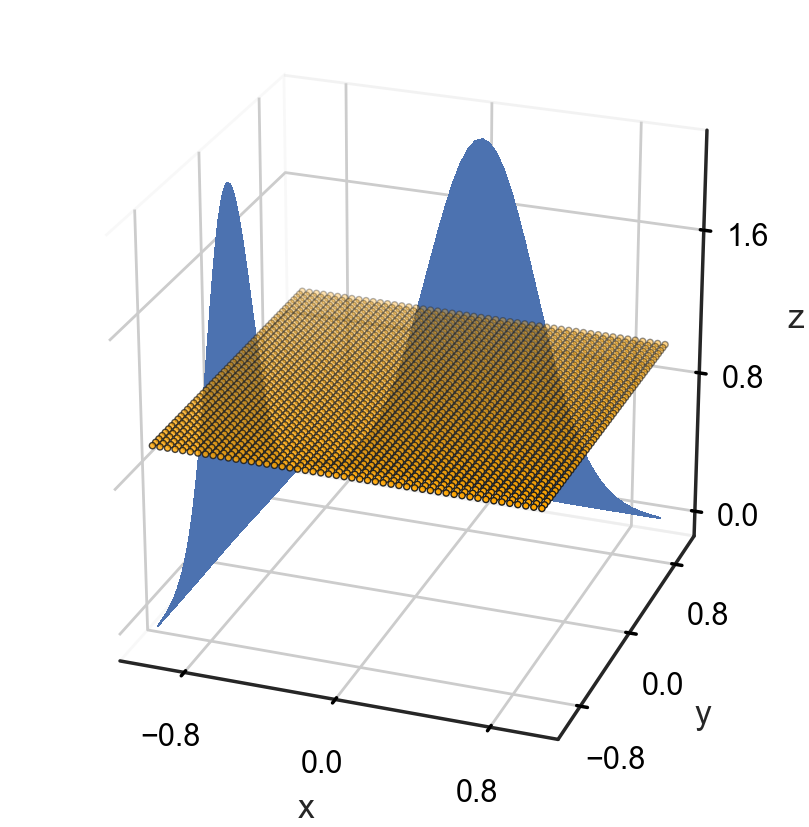

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, zdir='y', offset=1, levels=1, colors='b')
ax.contourf(X, Y, Z, zdir='x', offset=-1, levels=1, colors='b')
ax.scatter(*query_points.T, fc='orange', ec='k', s=5, lw=0.5)
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [24]:
# check if the orange dots are inside or out of the compliance zone
val = assess_compliance(query_points, points,
                        normals=normals)

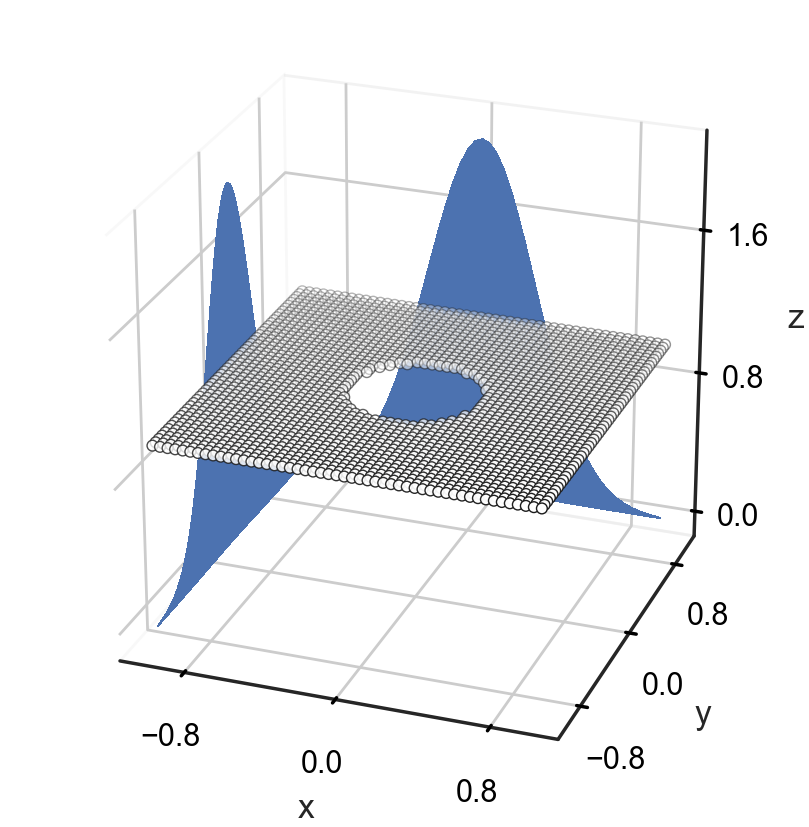

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, zdir='y', offset=1, levels=1, colors='b')
ax.contourf(X, Y, Z, zdir='x', offset=-1, levels=1, colors='b')
ax.scatter(*query_points[val > 0, ...].T, fc='w', ec='k', s=15, lw=0.5)
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [26]:
# find out the approximate radius where f(x, y) is ~1
idx = np.where(np.isclose(Z, 1, rtol=1e-2, atol=1e-2))
r = np.mean(np.sqrt(X[idx] ** 2 + Y[idx] ** 2))

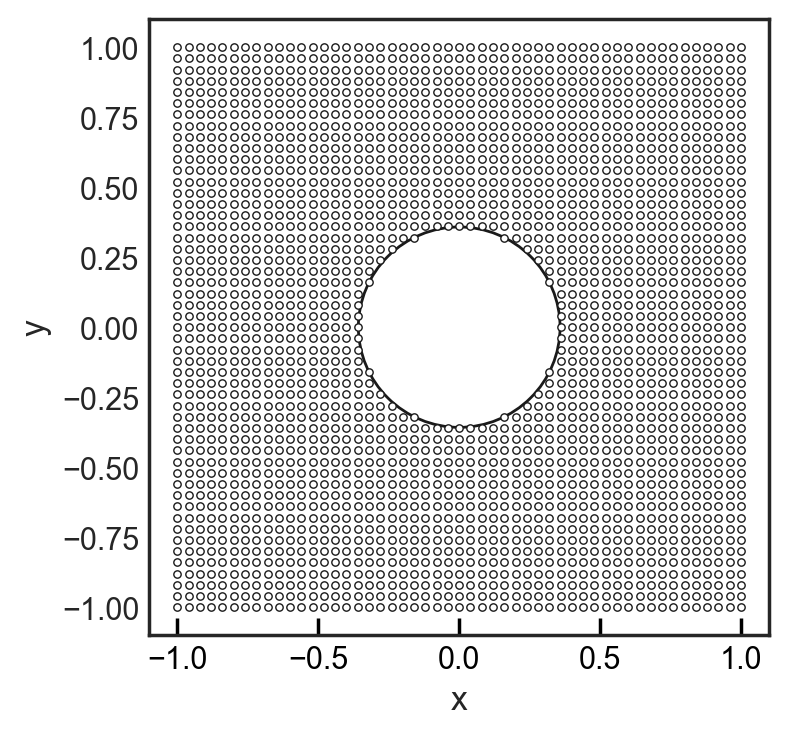

In [27]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
circle = patches.Circle((0, 0), r, fc='none', ec='k')
ax.add_patch(circle)
ax.scatter(*query_points[val > 0, :2].T,
           fc='w', ec='k', s=7, lw=0.5)
ax.set(xlabel='x', ylabel='y');

### Simple function to check whether a point is within the compliance-zone boundaries, vol. 2

The second presented implementation is based on the **Method 2** and is somewhat less robust as no SDF sampling is performed.
Instead, only the original points comprising the point cloud that represents the surface of the compliance-zone boundary are used.
This makes this method faster to execute and easier to implement, however there is no guarantee for convergence for complex boundary shapes as it is very sensitive on the number of examined closest points on the surface.

In [28]:
def assess_compliance_2(query_points,
                        evaluation_points,
                        sample_count=5,
                        normals=None,
                        k=None,
                        **kwargs):
    """Return the indicator stating whether the query point is out of
    the compliance-zone boundary whose surface is represented as the
    unstructured point cloud.

    Parameters
    ----------
    query_points : numpy.ndarray
        Tested point(s) of shape (M, 3), M is the number of points
        being assessed for compliance
    evaluation_points : numpy.ndarray
        Point cloud of shape (N, 3), N is the number of points on the
        surface of the compliance-zone boundaryc
    sample_count : int, optional
        Number of closest points in the point cloud relative to each
        query point
    normals : numpy.ndarray, optional
        Normals of shape (N, 3), where N is the number of points in the
        point cloud. Normals should point out of the compliance zone
    k : float, optional
        Number of nearest neighbors for normal estimation
    **kwargs : dict, optional
        Additional keyword arguments for normal estimation if normals
        are not provided

    Returns
    -------
    numpy.ndarray 
        Of booleans indicating whether the query point is out of the 
    """    
    # handle points
    size = evaluation_points.shape[0]
    if size < 10:
        raise ValueError('Number of points must be > 10')  # for robustness

    # compute normals
    if normals is None:
        if not k:
            k = int(2 * np.log(size))
            if k < 5:
                k = 5
            elif k > 30:
                k = 30
        normals = estimate_normals(evaluation_points, k)
        normals = orient_normals(evaluation_points, normals, k)
    normals = normals / np.linalg.norm(normals, axis=1).reshape(-1, 1)

    # find points on the compliance-zone boundary closest to the query point
    tree = spatial.KDTree(evaluation_points)    
    dist, idx = tree.query(query_points, k=sample_count, workers=-1)
    closest_points = evaluation_points[idx]
    
    # compute the dot product between the relative position and normal vector
    pos_vec = np.atleast_2d(query_points)[:, np.newaxis, :] - closest_points

    # count the positive values indicating that the point is located outside
    out = np.einsum('ijk,ijk->ij', pos_vec, normals[idx]) > 0
    out = np.sum(out, axis=1) >= sample_count * 0.5
    return out

In [29]:
# define query points to test an assessment function
query_points = np.c_[X.ravel(), Y.ravel(), np.ones_like(X).ravel()]

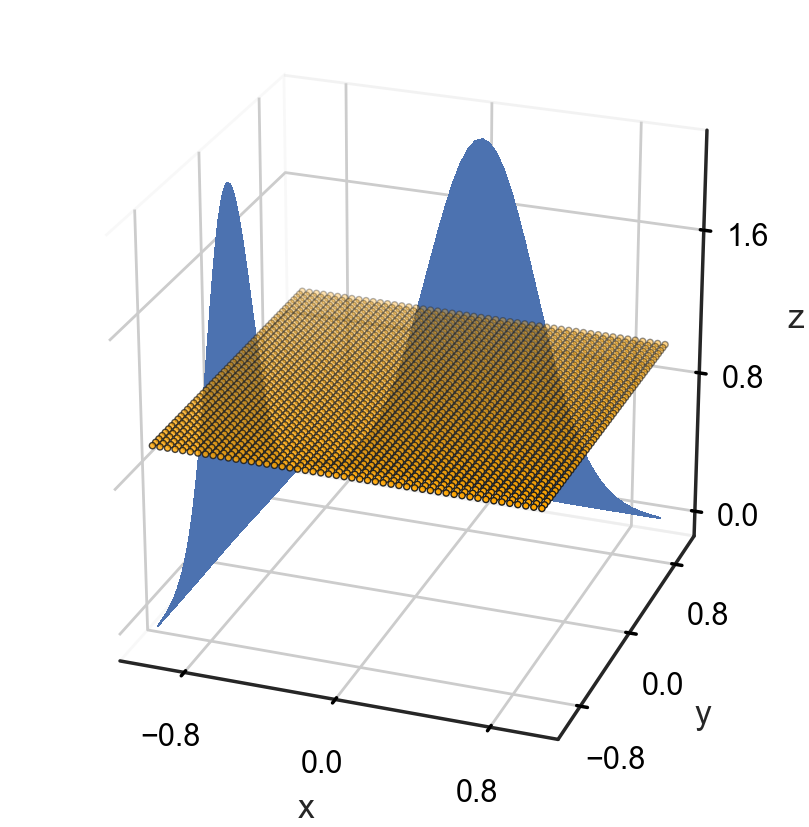

In [30]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, zdir='y', offset=1, levels=1, colors='b')
ax.contourf(X, Y, Z, zdir='x', offset=-1, levels=1, colors='b')
ax.scatter(*query_points.T, fc='orange', ec='k', s=5, lw=0.5)
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [31]:
# check if the orange dots are inside or out of the compliance zone
out = assess_compliance_2(query_points, points,
                          sample_count=5,
                          normals=normals)

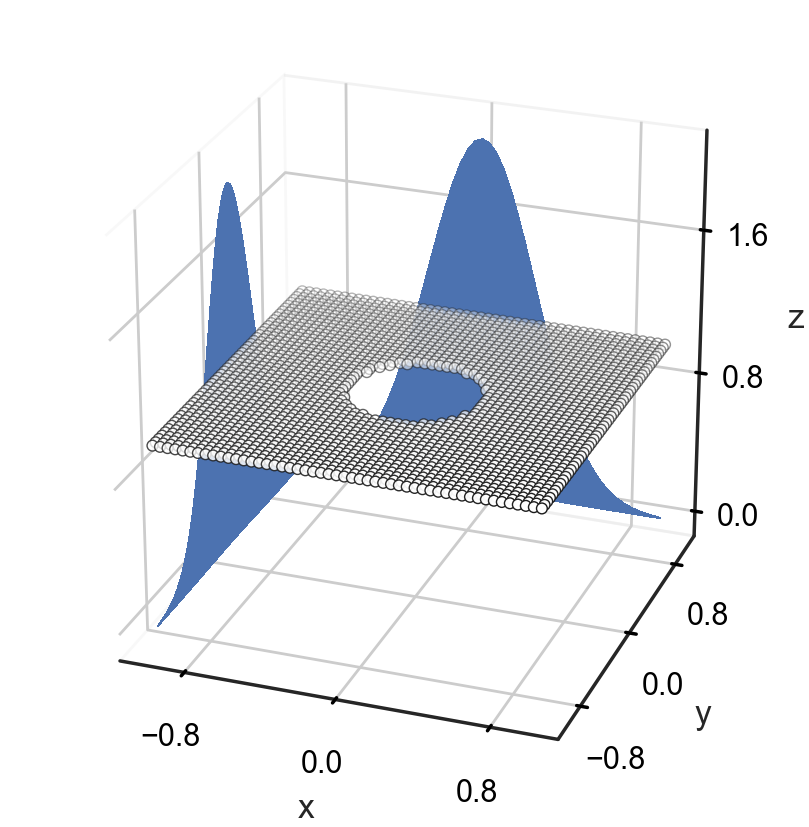

In [32]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, zdir='y', offset=1, levels=1, colors='b')
ax.contourf(X, Y, Z, zdir='x', offset=-1, levels=1, colors='b')
ax.scatter(*query_points[out, ...].T, fc='w', ec='k', s=15, lw=0.5)
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [33]:
# find out the approximate radius where f(x, y) is ~1
idx = np.where(np.isclose(Z, 1, rtol=1e-2, atol=1e-2))
r = np.mean(np.sqrt(X[idx] ** 2 + Y[idx] ** 2))

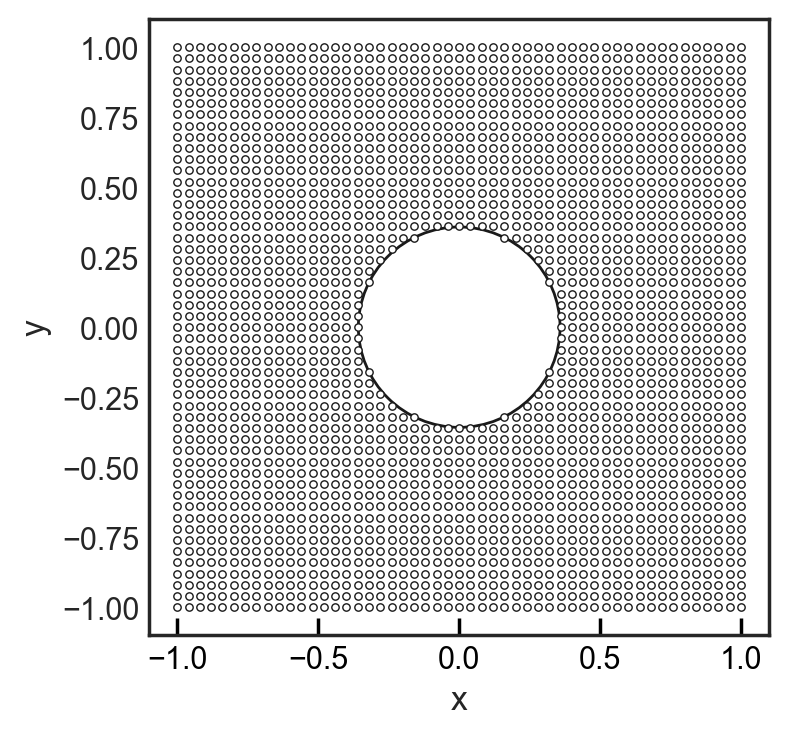

In [34]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
circle = patches.Circle((0, 0), r, fc='none', ec='k')
ax.add_patch(circle)
ax.scatter(*query_points[out, :2].T,
           fc='w', ec='k', s=7, lw=0.5)
ax.set(xlabel='x', ylabel='y');